### Plant disease classification using Convolution Neural Network Model¶
Diseased and healthy grape leaf images were used to train a deep learning architecture known as AlexNet. The model classifies the test images with 97% accuracy.

In [0]:
from keras import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.applications import vgg16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input as vgg_pi
from keras.applications.resnet50 import preprocess_input as resnet_pi
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import keras
from keras.callbacks import CSVLogger, ReduceLROnPlateau, EarlyStopping
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D
from keras.layers.normalization import BatchNormalization
import numpy as np


Using TensorFlow backend.


### Helper functions

In [0]:
def smooth_curve(points, factor=0.8):
  """
  Helper function to help smooth accuracy/loss plots using an exponential
  moving average of the loss and accuracy values. 
  """
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

def get_plots(history, smooth=False):
  """
  Helper function to plot training/validation accuracy/loss.
  @param history - Keras model history 
  @param smooth - Boolean for whether to smooth plots or not
  """
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc)+1)
  
  if smooth == True:
    acc = smooth_curve(acc)
    val_acc = smooth_curve(val_acc)
    loss = smooth_curve(loss)
    val_loss = smooth_curve(val_loss)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc,'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
  
def get_metrics(model, generator, steps, target_names=[]):
  """
  Function to print out confusion matrix and classification report.
  """
  target_names = ['black_measles', 'black_rot', 'leaf_blight', 'phylloxera', 'healthy']
  abbreviations = ['BM', 'BR', 'LB', 'PH', 'H']
  
  # Get predictions for data
  y_pred = model.predict_generator(generator=generator, steps=steps)
  y_pred = np.argmax(a=y_pred, axis=1)
  
  # Get confusion matix
  cnf_mat = confusion_matrix(y_true=generator.classes, y_pred=y_pred)
  fig, ax = plt.subplots(1)
  ax = sns.heatmap(cnf_mat, ax=ax, cmap=plt.cm.Blues, annot=True, fmt='g')
  ax.set_xticklabels(abbreviations)
  ax.set_yticklabels(abbreviations)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')
  plt.show()
  
  # Get classification report
  print('Classification Report')
  print(classification_report(y_true=generator.classes, y_pred=y_pred, 
                              target_names=target_names))

### Training data geneation

In [0]:
# Training data generator with data augmentation
train_datagen = ImageDataGenerator(
                  rescale=1./100,
                  rotation_range=40,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  shear_range=0.1,
                  zoom_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True)

# No data augmentation for validation data
test_datagen = ImageDataGenerator(rescale=1./100)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(img_height, img_width),
                    color_mode='rgb',
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True, 
                    seed=42)

validation_generator = test_datagen.flow_from_directory(
                          validation_dir,
                          target_size=(img_height, img_width),
                          color_mode='rgb',
                          batch_size=batch_size,
                          class_mode='categorical')



Found 3799 images belonging to 5 classes.
Found 949 images belonging to 5 classes.


### Constructing the model from scratch

In [0]:
model = Sequential()
model.add(Conv2D(64, (11, 11), input_shape=input_shape, padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size= (3, 3)))

model.add(Conv2D(128, (7, 7), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Convolution2D(192, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())
model.add(Dense(12 * 12 * 256, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5 , activation='softmax'))
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 100, 100, 64)      23296     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100, 100, 64)      256       
_________________________________________________________________
activation_4 (Activation)    (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 33, 33, 128)       401536    
_________________________________________________________________
batch_normalization_6 (Batch (None, 33, 33, 128)       512       
_________________________________________________________________
activation_5 (Activation)    (None, 33, 33, 128)      

In [0]:
##set hyperparameters to reduce overfitting
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('alexnet_scratch_log.csv')

In [0]:
#compile the model
model.compile(optimizer='Adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

### Run the model

In [0]:
history = model.fit_generator(train_generator, nb_epoch=epochs, steps_per_epoch=3799 // batch_size,
                                    validation_data=validation_generator, nb_val_samples=949 // batch_size,
                                    class_weight='auto', callbacks=[lr_reducer, early_stopper, csv_logger])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=189, validation_data=<keras.pre..., class_weight="auto", callbacks=[<keras.ca..., epochs=15, validation_steps=47)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/15
189/189 [==============================] - 28s 146ms/step - loss: 0.1982 - accuracy: 0.9373 - val_loss: 0.6540 - val_accuracy: 0.8181
Epoch 2/15
189/189 [==============================] - 27s 142ms/step - loss: 0.1301 - accuracy: 0.9587 - val_loss: 3.1345 - val_accuracy: 0.7793
Epoch 3/15
189/189 [==============================] - 27s 141ms/step - loss: 0.1343 - accuracy: 0.9537 - val_loss: 10.4036 - val_accuracy: 0.6125
Epoch 4/15
189/189 [==============================] - 26s 140ms/step - loss: 0.1113 - accuracy: 0.9603 - val_loss: 0.7895 - val_accuracy: 0.6835
Epoch 5/15
189/189 [==============================] - 27s 140ms/step - loss: 0.1161 - accuracy: 0.9616 - val_loss: 3.2302 - val_accuracy: 0.4672
Epoch 6/15
189/189 [==============================] - 26s 140ms/step - loss: 0.1225 - accuracy: 0.9656 - val_loss: 2.1753 - val_accuracy: 0.7772
Epoch 7/15
189/189 [==============================] - 26s 140ms/step - loss: 0.0670 - accuracy: 0.9786 - val_loss: 0.0293 - val_a

### Test data generator

In [0]:
#test data generator
test_gen = test_datagen.flow_from_directory(
                test_dir,
                target_size=(img_height, img_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 1187 images belonging to 5 classes.


### Model Evaluation

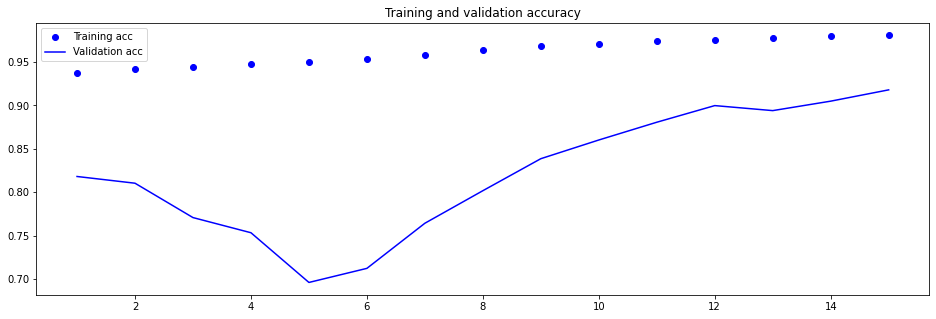

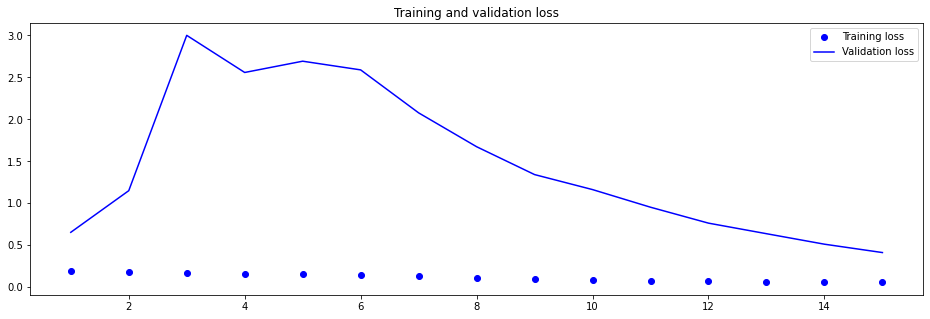

In [0]:
get_plots(history,smooth=True) #the training and validation accuracy and losses in each epoch

In [0]:
val_test_gen = test_datagen.flow_from_directory(
                validation_dir,
                target_size=(img_height, img_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 949 images belonging to 5 classes.


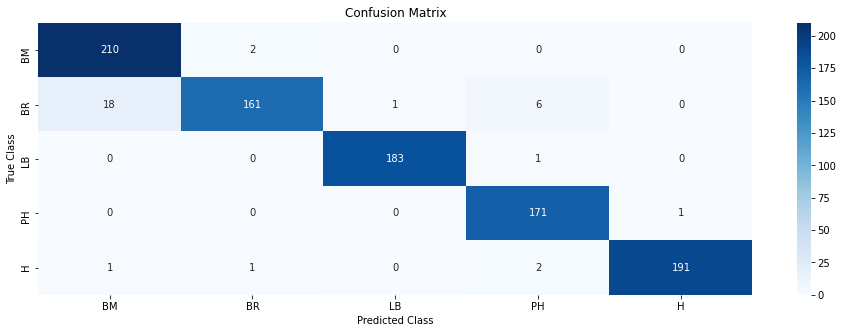

Classification Report
               precision    recall  f1-score   support

black_measles       0.92      0.99      0.95       212
    black_rot       0.98      0.87      0.92       186
  leaf_blight       0.99      0.99      0.99       184
   phylloxera       0.95      0.99      0.97       172
      healthy       0.99      0.98      0.99       195

     accuracy                           0.97       949
    macro avg       0.97      0.96      0.97       949
 weighted avg       0.97      0.97      0.96       949



In [0]:
model = load_model(filepath=os.path.join(model_dir, 'alex-5.h5'))

# Get confusion matrix and classification report
get_metrics(model, generator=val_test_gen, steps=total_val)

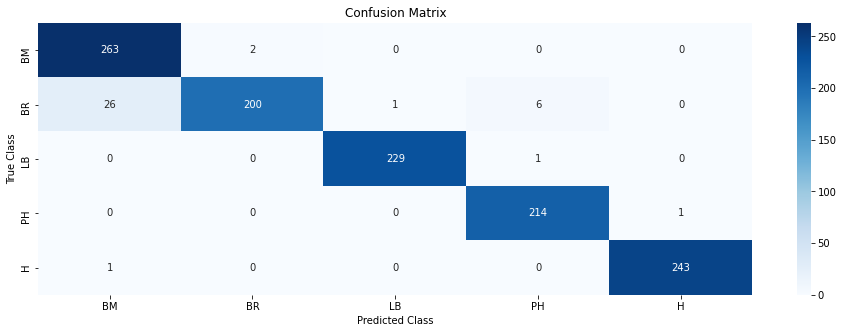

Classification Report
               precision    recall  f1-score   support

black_measles       0.91      0.99      0.95       265
    black_rot       0.99      0.86      0.92       233
  leaf_blight       1.00      1.00      1.00       230
   phylloxera       0.97      1.00      0.98       215
      healthy       1.00      1.00      1.00       244

     accuracy                           0.97      1187
    macro avg       0.97      0.97      0.97      1187
 weighted avg       0.97      0.97      0.97      1187



In [0]:
# Get confusion matrix and classification report
get_metrics(model, generator=test_gen, steps=total_test)

We can see that the most misclassifcations occurred for black rot and black measels.